# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 3
# Multiple Linear Regression, Subset Selection, Cross Validation

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately):

Enrollment Status (109A, 121A, 209A, or E109A):

Import libraries:

In [80]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
%matplotlib inline
import scipy as sp
import urllib
import bs4 #this is beautiful soup
import time
import operator
import socket
import seaborn as sns
#import cPickle
import re # regular expressions

# Forecasting Bike Sharing Usage

In this homework, we will focus on multiple linear regression and will explore techniques for subset selection. The specific task is to build a regression model for a bike share system that can predict the total number of bike rentals in a given day, based on attributes about the day. Such a demand forecasting model would be useful in planning the number of bikes that need to be available in the system on any given day, and also in monitoring traffic in the city. The data for this problem was collected from the Capital Bikeshare program in Washington D.C. over two years.   

The data set is provided in the files `Bikeshare_train.csv` and `Bikeshare_test.csv`, as separate training and test sets. Each row in these files contains 10 attributes describing a day and its weather:
- season (1 = spring, 2 = summer, 3 = fall, 4 = winter)
- month (1 through 12, with 1 denoting Jan)
- holiday (1 = the day is a holiday, 0 = otherwise)
- day_of_week (0 through 6, with 0 denoting Sunday)
- workingday (1 = the day is neither a holiday or weekend, 0 = otherwise)
- weather 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp (temperature in Celsius)
- atemp (apparent temperature, or relative outdoor temperature, in Celsius)
- humidity (relative humidity)
- windspeed (wind speed)

and the last column 'count' contains the response variable, i.e. total number of bike rentals on the day.


## Part (a): Data Exploration & Preprocessing

As a first step, identify important characteristics of the data using suitable visualizations when necessary. Some of the questions you may ask include (but are not limited to):

- How does the number of bike rentals vary between weekdays and weekends? 
- How about bike rentals on holidays?
- What effect does the season have on the bike rentals on a given day?
- Is the number of bike rentals lower than average when there is rain or snow?
- How does temperature effect bike rentals?
- Do any of the numeric attributes have a clear non-linear dependence with number of the bike rentals?



In [81]:
#load Bikeshare_train
dftrain=pd.read_csv("d:/Users/Home/Desktop/Open-U/Data Science/a-2017-master/HW/hw_3/Bikeshare_train.csv")
df_test=pd.read_csv("d:/Users/Home/Desktop/Open-U/Data Science/a-2017-master/HW/hw_3/Bikeshare_test.csv")
dftrain=dftrain.rename(columns={"Unnamed: 0":"name"})
dftrain = dftrain.drop('name', 1)
df_test=df_test.rename(columns={"Unnamed: 0":"name"})
df_test = df_test.drop('name', 1)
#dftrain=dftrain.sort_values(by=['month'])
dftrain.head()


,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
0,2.0,5.0,0.0,2.0,1.0,2.0,24.0,26.0,76.5833,0.118167,6073.0
1,4.0,12.0,0.0,2.0,1.0,1.0,15.0,19.0,73.3750,0.174129,6606.0
2,2.0,6.0,0.0,4.0,1.0,1.0,26.0,28.0,56.9583,0.253733,7363.0
3,4.0,12.0,0.0,0.0,0.0,1.0,0.0,4.0,58.6250,0.169779,2431.0
4,3.0,9.0,0.0,3.0,1.0,3.0,23.0,23.0,91.7083,0.097021,1996.0


In [82]:
mean_count=np.mean(dftrain['count'])
dftrain.shape

(331, 11)

In [83]:
#We have a SMALL data set!- splitting to train & validation is not recomended, but cross-validation would be required.

In [84]:
# there are 3 values for weather being mentioned inspite of the anounced 4
np.unique(dftrain.weather)

array([ 1.,  2.,  3.])

In [85]:
#let us group data by month and see what kind of dependence do we have
ordered=dftrain.groupby(['month']).sum()
ordered=ordered.reset_index()

In [86]:
counts=np.array(ordered[['count']])
months=np.array([[1,2,3,4,5,6,7,8,9,10,11,12]])
months = months.reshape(12,1)
print(counts.shape,months.shape)

(12, 1) (12, 1)


In [87]:
selected=ordered[['month','count']]

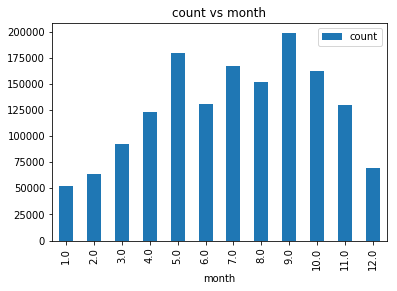

In [88]:
selected.plot.bar(x='month',y='count',title='count vs month')

In [89]:
names=dftrain.columns.values
#let us remove the temp	atemp	humidity	windspeed and create data frame where for each column we will use plot bar
dftrain_sel=dftrain[['season','month','holiday','day_of_week','workingday','weather','count']]

In [90]:
#created function to replace the number of season in words
def asign_season(vec):
    seasons_w=[]    
    for s in vec:      
        if(s==1.0):
            seasons_w.append('spring')          
        if(s==2.0):
            seasons_w.append('summer')
        if(s==3.0):
            seasons_w.append('fall')
        if(s==4.0):
            seasons_w.append('winter')   
    return seasons_w        

In [91]:
seasons_w=asign_season(np.array(dftrain[['season']]))

In [92]:
def plot_bars(dataframe):
    names=dataframe.columns.values
    for name in names:      
        ordered=dataframe.groupby([name]).sum()
        ordered=ordered.reset_index()          
        ordered.plot.bar(x=name,y=names[6],title='count vs '+name)        

In [93]:
dftrain_sel=dftrain_sel.assign(season_words=seasons_w)
dftrain_sel=dftrain_sel[['season_words','month','holiday','day_of_week','workingday','weather','count']]

KeyError: 'count'

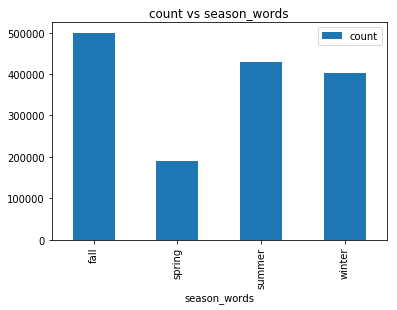

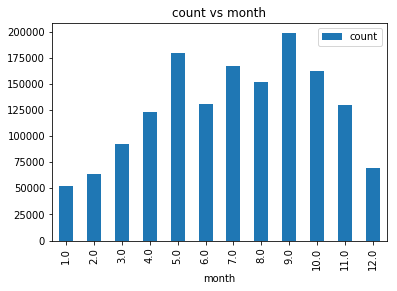

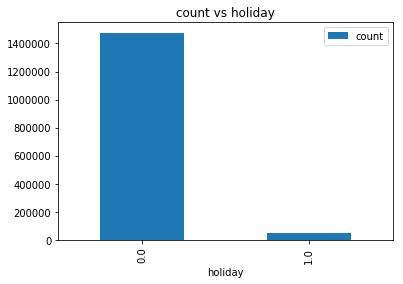

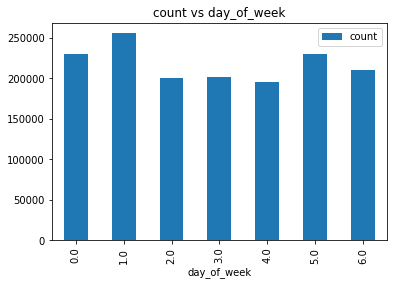

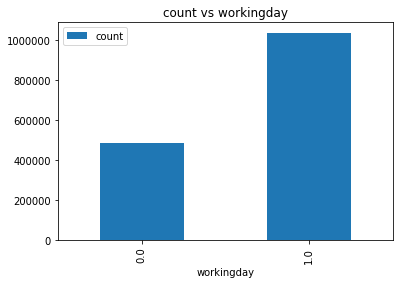

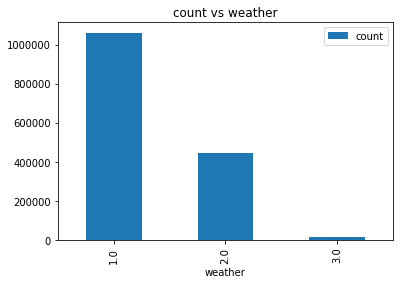

In [94]:
plot_bars(dftrain_sel)

In [ ]:
temp_dep=dftrain['temp']
atemp_dep=dftrain['atemp']
humidity_dep=dftrain['humidity']
windspeed_dep=dftrain['windspeed']
count_dep=dftrain['count']
plt.scatter(temp_dep,count_dep,c='red')
plt.title('temp_dep-count_dep')


Text(0.5,1,'atemp_dep-count_dep')

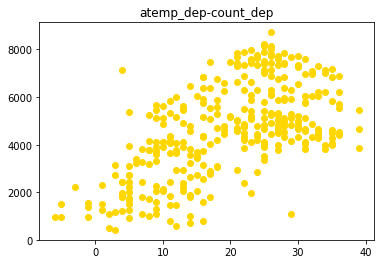

In [95]:
plt.scatter(atemp_dep,count_dep,c='gold')
plt.title('atemp_dep-count_dep')

Text(0.5,1,'atemp_dep-count_dep')

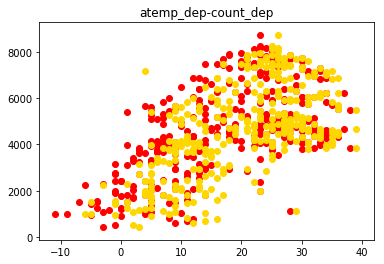

In [96]:
plt.scatter(temp_dep,count_dep,c='red')

plt.title('temp_dep-count_dep')
plt.scatter(atemp_dep,count_dep,c='gold')
plt.title('atemp_dep-count_dep')
#temp & atemp seem to be the same

Text(0.5,1,'humidity_dep-count_dep')

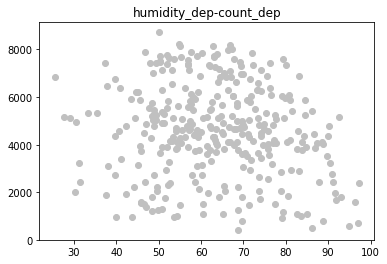

In [97]:
plt.scatter(humidity_dep,count_dep,c='silver')
plt.title('humidity_dep-count_dep')

Text(0.5,1,'windspeed-count_dep')

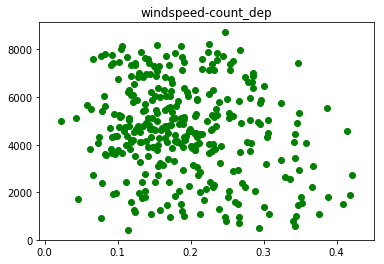

In [98]:
plt.scatter(windspeed_dep,count_dep,c='green')
plt.title('windspeed-count_dep')

In [99]:
#Should check for correlation
# 1.season & month are dependent: 
# 2. holiday / day_of_week / working_day 
# 3.woeather & humidity, wind_speed.....
#Rentals:from low to high by season: spring->winter->summer->fall, while spring is the lowet , fall is the highest, and summer and winter does not 
#differ that much
#Rentals:according to month number: winter->spring->summer->fall
#Higher renatals:working days &good weather

In [100]:
#How does the number of bike rentals vary between weekdays and weekends?-
# - the number of bike rentals slightly increases on the weekend
#How about bike rentals on holidays?
#-on a not-holiday day the are much more bike rentals
#What effect does the season have on the bike rentals on a given day?
#-more bike rentals on spring(1),summer(2),fall(3)
#Is the number of bike rentals lower than average when there is rain or snow?
#-when there is rain(3), (no 4 in the data), the bike rentals are lower
#How does temperature effect bike rentals?
#-temp and atemp seen to have some linear depemdence with the rentals num.
# temp/atemp seem to be strongly correlated .....
#Do any of the numeric attributes have a clear non-linear dependence with number of the bike rentals?
#-humidity and wind speed ?

In [101]:
#Categorical variables:
#season
#holiday
#workingday
#month
#day of week
#weather

In [102]:
dftrain_oneH=dftrain
dftest_oneH=df_test
dftrain_oneH.head()



,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
0,2.0,5.0,0.0,2.0,1.0,2.0,24.0,26.0,76.5833,0.118167,6073.0
1,4.0,12.0,0.0,2.0,1.0,1.0,15.0,19.0,73.3750,0.174129,6606.0
2,2.0,6.0,0.0,4.0,1.0,1.0,26.0,28.0,56.9583,0.253733,7363.0
3,4.0,12.0,0.0,0.0,0.0,1.0,0.0,4.0,58.6250,0.169779,2431.0
4,3.0,9.0,0.0,3.0,1.0,3.0,23.0,23.0,91.7083,0.097021,1996.0


In [103]:
#seasons_bin=asign_season_weather_bin(np.array(dftrain[['season']]))
#dftrain_oneH=dftrain.assign(season_binary=seasons_bin)
#weather_bin=asign_season_weather_bin(np.array(dftrain[['weather']]))
#dftrain_oneH=dftrain_oneH.assign(weather_binary=weather_bin)

#holiday_bin=asign_hday_wday_bin(np.array(dftrain[['holiday']]))
#dftrain_oneH=dftrain_oneH.assign(holiday_binary=holiday_bin)
#workingday_bin=asign_hday_wday_bin(np.array(dftrain[['workingday']]))
#dftrain_oneH=dftrain_oneH.assign(workingday_binary=workingday_bin)
#dftrain_oneH[['season_binary','month','holiday_binary','day_of_week','workingday_binary','weather_binary','temp','atemp','humidity','windspeed','count']].head()

In [104]:
temp_mean=np.mean(dftrain_oneH[['temp']])
temp_SD=np.std(dftrain_oneH[['temp']])
dftrain_oneH['temp_new']=dftrain_oneH['temp'].apply(lambda x:(x-temp_mean)/temp_SD)
print(temp_mean,temp_SD)

atemp_mean=np.mean(dftrain_oneH[['atemp']])
atemp_SD=np.std(dftrain_oneH[['atemp']])
dftrain_oneH['atemp_new']=dftrain_oneH['atemp'].apply(lambda x:(x-atemp_mean)/atemp_SD)
#f_atemp=list(map(lambda x:(x-atemp_mean)/atemp_SD,atemp_list))
print(atemp_mean,atemp_SD)

humidity_mean=np.mean(dftrain_oneH[['humidity']])
humidity_SD=np.std(dftrain_oneH[['humidity']])
dftrain_oneH['humidity_new']=dftrain_oneH['humidity'].apply(lambda x:(x-humidity_mean)/humidity_SD)
print(humidity_mean,humidity_SD)

windspeed_mean=np.mean(dftrain_oneH[['windspeed']])
windspeed_SD=np.std(dftrain_oneH[['windspeed']])
dftrain_oneH['windspeed_new']=dftrain_oneH['windspeed'].apply(lambda x:(x-windspeed_mean)/windspeed_SD)
print(windspeed_mean,windspeed_SD)
dftrain_oneH.head()

temp    17.018127
dtype: float64 temp    11.175595
dtype: float64
atemp    19.543807
dtype: float64 atemp    9.915979
dtype: float64
humidity    63.385776
dtype: float64 humidity    14.313119
dtype: float64
windspeed    0.190833
dtype: float64 windspeed    0.078122
dtype: float64


,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count,temp_new,atemp_new,humidity_new,windspeed_new
0,2.0,5.0,0.0,2.0,1.0,2.0,24.0,26.0,76.5833,0.118167,6073.0,0.624743,0.651090,0.922058,-0.930164
1,4.0,12.0,0.0,2.0,1.0,1.0,15.0,19.0,73.3750,0.174129,6606.0,-0.180583,-0.054841,0.697907,-0.213825
2,2.0,6.0,0.0,4.0,1.0,1.0,26.0,28.0,56.9583,0.253733,7363.0,0.803704,0.852785,-0.449062,0.805143
3,4.0,12.0,0.0,0.0,0.0,1.0,0.0,4.0,58.6250,0.169779,2431.0,-1.522794,-1.567551,-0.332616,-0.269507
4,3.0,9.0,0.0,3.0,1.0,3.0,23.0,23.0,91.7083,0.097021,1996.0,0.535262,0.348548,1.978781,-1.200843


In [105]:
dfrescaled=dftrain_oneH[[#'season_binary',
                         'month',
                      #   'holiday_binary',
                         'day_of_week',
                        # 'workingday_binary',
                       #  'weather_binary',
                         'temp_new','atemp_new','humidity_new','windspeed_new','count']].head()
dftrain_oneH.head(10)

,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count,temp_new,atemp_new,humidity_new,windspeed_new
0,2.0,5.0,0.0,2.0,1.0,2.0,24.0,26.0,76.5833,0.118167,6073.0,0.624743,0.651090,0.922058,-0.930164
1,4.0,12.0,0.0,2.0,1.0,1.0,15.0,19.0,73.3750,0.174129,6606.0,-0.180583,-0.054841,0.697907,-0.213825
2,2.0,6.0,0.0,4.0,1.0,1.0,26.0,28.0,56.9583,0.253733,7363.0,0.803704,0.852785,-0.449062,0.805143
3,4.0,12.0,0.0,0.0,0.0,1.0,0.0,4.0,58.6250,0.169779,2431.0,-1.522794,-1.567551,-0.332616,-0.269507
4,3.0,9.0,0.0,3.0,1.0,3.0,23.0,23.0,91.7083,0.097021,1996.0,0.535262,0.348548,1.978781,-1.200843
5,2.0,5.0,0.0,2.0,1.0,2.0,24.0,26.0,69.7083,0.342667,4451.0,0.624743,0.651090,0.441729,1.943539
6,4.0,11.0,0.0,4.0,1.0,1.0,7.0,11.0,33.3478,0.347835,5315.0,-0.896429,-0.861620,-2.098632,2.009692
7,2.0,6.0,0.0,2.0,1.0,1.0,23.0,26.0,50.7083,0.269283,4891.0,0.535262,0.651090,-0.885724,1.004190
8,3.0,9.0,0.0,6.0,0.0,1.0,23.0,26.0,50.1667,0.247521,8714.0,0.535262,0.651090,-0.923564,0.725627
9,3.0,8.0,0.0,3.0,1.0,1.0,30.0,30.0,61.9583,0.169771,7347.0,1.161627,1.054479,-0.099732,-0.269609


In [106]:
#season
dummies_s= pd.get_dummies(dftrain_oneH['season']).rename(columns=lambda x: 'season_' + str(x))
dftrain_oneH= pd.concat([dftrain_oneH, dummies_s], axis=1)
#dftrain_d = dftrain_d.drop(['season'], inplace=True, axis=1)
#holiday
dummies_h= pd.get_dummies(dftrain_oneH['holiday']).rename(columns=lambda x: 'holiday_' + str(x))
dftrain_oneH= pd.concat([dftrain_oneH, dummies_h], axis=1)
#workingday
dummies_wd= pd.get_dummies(dftrain_oneH['workingday']).rename(columns=lambda x: 'workingday_' + str(x))
dftrain_oneH= pd.concat([dftrain_oneH, dummies_wd], axis=1)
#wather
dummies_w= pd.get_dummies(dftrain_oneH['weather']).rename(columns=lambda x: 'weather_' + str(x))
dftrain_oneH= pd.concat([dftrain_oneH, dummies_w], axis=1)
dftrain_oneH.head()

,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,...,season_2.0,season_3.0,season_4.0,holiday_0.0,holiday_1.0,workingday_0.0,workingday_1.0,weather_1.0,weather_2.0,weather_3.0
0,2.0,5.0,0.0,2.0,1.0,2.0,24.0,26.0,76.5833,0.118167,...,1,0,0,1,0,0,1,0,1,0
1,4.0,12.0,0.0,2.0,1.0,1.0,15.0,19.0,73.3750,0.174129,...,0,0,1,1,0,0,1,1,0,0
2,2.0,6.0,0.0,4.0,1.0,1.0,26.0,28.0,56.9583,0.253733,...,1,0,0,1,0,0,1,1,0,0
3,4.0,12.0,0.0,0.0,0.0,1.0,0.0,4.0,58.6250,0.169779,...,0,0,1,1,0,1,0,1,0,0
4,3.0,9.0,0.0,3.0,1.0,3.0,23.0,23.0,91.7083,0.097021,...,0,1,0,1,0,0,1,0,0,1


In [107]:
dummies_m= pd.get_dummies(dftrain['month']).rename(columns=lambda x: 'month_' + str(x))
dftrain_oneH= pd.concat([dftrain_oneH, dummies_m], axis=1)

dummies_dow= pd.get_dummies(dftrain['day_of_week']).rename(columns=lambda x: 'day_of_week_' + str(x))
dftrain_oneH= pd.concat([dftrain_oneH, dummies_dow], axis=1)

In [108]:
#test rescale

temp_mean_t=np.mean(dftest_oneH[['temp']])
temp_SD_t=np.std(dftest_oneH[['temp']])
dftest_oneH['temp_new']=dftest_oneH['temp'].apply(lambda x:(x-temp_mean_t)/temp_SD_t)
print(temp_mean,temp_SD)

atemp_mean_t=np.mean(dftest_oneH[['atemp']])
atemp_SD_t=np.std(dftest_oneH[['atemp']])
dftest_oneH['atemp_new']=dftest_oneH['atemp'].apply(lambda x:(x-atemp_mean_t)/atemp_SD_t)
#f_atemp_t=list(map(lambda x:(x-atemp_mean)/atemp_SD,atemp_list))
print(atemp_mean,atemp_SD)

humidity_mean_t=np.mean(dftest_oneH[['humidity']])
humidity_SD_t=np.std(dftest_oneH[['humidity']])
dftest_oneH['humidity_new']=dftest_oneH['humidity'].apply(lambda x:(x-humidity_mean_t)/humidity_SD_t)
print(humidity_mean,humidity_SD)

windspeed_mean_t=np.mean(dftest_oneH[['windspeed']])
windspeed_SD_t=np.std(dftest_oneH[['windspeed']])
dftest_oneH['windspeed_new']=dftest_oneH['windspeed'].apply(lambda x:(x-windspeed_mean_t)/windspeed_SD_t)
print(windspeed_mean,windspeed_SD)
dftest_oneH.head(10)

#season
dummies_s_t= pd.get_dummies(dftest_oneH['season']).rename(columns=lambda x: 'season_' + str(x))
dftest_oneH= pd.concat([dftest_oneH, dummies_s_t], axis=1)
#dftrain_d = dftrain_d.drop(['season'], inplace=True, axis=1)
#holiday
dummies_h_t= pd.get_dummies(dftest_oneH['holiday']).rename(columns=lambda x: 'holiday_' + str(x))
dftest_oneH= pd.concat([dftest_oneH, dummies_h_t], axis=1)
#workingday
dummies_wd_t= pd.get_dummies(dftest_oneH['workingday']).rename(columns=lambda x: 'workingday_' + str(x))
dftest_oneH= pd.concat([dftest_oneH, dummies_wd_t], axis=1)
#wather
dummies_w_t= pd.get_dummies(dftest_oneH['weather']).rename(columns=lambda x: 'weather_' + str(x))
dftest_oneH= pd.concat([dftest_oneH, dummies_w_t], axis=1)
dftest_oneH.head(10)

dummies_m_t= pd.get_dummies(dftest_oneH['month']).rename(columns=lambda x: 'month_' + str(x))
dftest_oneH= pd.concat([dftest_oneH, dummies_m_t], axis=1)

dummies_dow_t= pd.get_dummies(dftest_oneH['day_of_week']).rename(columns=lambda x: 'day_of_week_' + str(x))
dftest_oneH= pd.concat([dftest_oneH, dummies_dow_t], axis=1)

dftest_oneH.head()

temp    17.018127
dtype: float64 temp    11.175595
dtype: float64
atemp    19.543807
dtype: float64 atemp    9.915979
dtype: float64
humidity    63.385776
dtype: float64 humidity    14.313119
dtype: float64
windspeed    0.190833
dtype: float64 windspeed    0.078122
dtype: float64


,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,...,month_10.0,month_11.0,month_12.0,day_of_week_0.0,day_of_week_1.0,day_of_week_2.0,day_of_week_3.0,day_of_week_4.0,day_of_week_5.0,day_of_week_6.0
0,1.0,2.0,0.0,4.0,1.0,1.0,2.0,6.0,56.2083,0.194037,...,0,0,0,0,0,0,0,1,0,0
1,1.0,12.0,0.0,4.0,1.0,2.0,1.0,3.0,65.2917,0.350133,...,0,0,1,0,0,0,0,1,0,0
2,2.0,6.0,0.0,4.0,1.0,2.0,36.0,37.0,56.8333,0.149883,...,0,0,0,0,0,0,0,1,0,0
3,1.0,2.0,0.0,1.0,1.0,1.0,8.0,12.0,49.0833,0.268033,...,0,0,0,0,1,0,0,0,0,0
4,2.0,5.0,0.0,0.0,0.0,1.0,28.0,29.0,69.7083,0.215171,...,0,0,0,1,0,0,0,0,0,0


your answers here

In [109]:
cols = dftrain_oneH.columns.tolist()
#cols

In [110]:
dftrain_d = dftrain_oneH[[
 'season',
    'season_1.0', 'season_2.0', 'season_3.0', 'season_4.0',
 'month',
    'month_1.0', 'month_2.0', 'month_3.0', 'month_4.0', 'month_5.0', 'month_6.0', 'month_7.0', 'month_8.0', 'month_9.0',
 'month_10.0', 'month_11.0', 'month_12.0',
  'holiday', 
    'holiday_0.0', 'holiday_1.0',
 'day_of_week', 
    'day_of_week_0.0', 'day_of_week_1.0', 'day_of_week_2.0', 'day_of_week_3.0', 'day_of_week_4.0', 'day_of_week_5.0',
    'day_of_week_6.0',
 'workingday', 
    'workingday_0.0', 'workingday_1.0',
 'weather', 
    'weather_1.0', 'weather_2.0', 'weather_3.0',
 'temp_new',
 'atemp_new',
 'humidity_new',
 'windspeed_new',
 'count',]]
dftrain_d.head(10)

,season,season_1.0,season_2.0,season_3.0,season_4.0,month,month_1.0,month_2.0,month_3.0,month_4.0,...,workingday_1.0,weather,weather_1.0,weather_2.0,weather_3.0,temp_new,atemp_new,humidity_new,windspeed_new,count
0,2.0,0,1,0,0,5.0,0,0,0,0,...,1,2.0,0,1,0,0.624743,0.651090,0.922058,-0.930164,6073.0
1,4.0,0,0,0,1,12.0,0,0,0,0,...,1,1.0,1,0,0,-0.180583,-0.054841,0.697907,-0.213825,6606.0
2,2.0,0,1,0,0,6.0,0,0,0,0,...,1,1.0,1,0,0,0.803704,0.852785,-0.449062,0.805143,7363.0
3,4.0,0,0,0,1,12.0,0,0,0,0,...,0,1.0,1,0,0,-1.522794,-1.567551,-0.332616,-0.269507,2431.0
4,3.0,0,0,1,0,9.0,0,0,0,0,...,1,3.0,0,0,1,0.535262,0.348548,1.978781,-1.200843,1996.0
5,2.0,0,1,0,0,5.0,0,0,0,0,...,1,2.0,0,1,0,0.624743,0.651090,0.441729,1.943539,4451.0
6,4.0,0,0,0,1,11.0,0,0,0,0,...,1,1.0,1,0,0,-0.896429,-0.861620,-2.098632,2.009692,5315.0
7,2.0,0,1,0,0,6.0,0,0,0,0,...,1,1.0,1,0,0,0.535262,0.651090,-0.885724,1.004190,4891.0
8,3.0,0,0,1,0,9.0,0,0,0,0,...,0,1.0,1,0,0,0.535262,0.651090,-0.923564,0.725627,8714.0
9,3.0,0,0,1,0,8.0,0,0,0,0,...,1,1.0,1,0,0,1.161627,1.054479,-0.099732,-0.269609,7347.0


In [111]:
#dftrain_d

We next require you to pre-process the categorical and numerical attributes in the data set:

- Notice that this data set contains categorical attributes with two or more categories. **Why can't they be directly used as predictors?** Convert these categorical attributes into multiple binary attributes using one-hot encoding: in the place of every categorical attribute $x_j$ that has categories $1, \ldots, K_j$, introduce $K_j-1$ binary predictors $x_{j1}, \ldots, x_{j,K_j-1}$ where $x_{jk}$ is 1 whenever $x_j = k$ and 0 otherwise. 
** Why is it okay to not have a binary column for the $K_j$-th category? **

- Since the attributes are in different scales, it is a good practice to standardize the continuous predictors, i.e. to scale each continuous predictor to have zero mean and a standard deviation of 1. This can be done by applying the following transform to each continuous-valued predictor $j$:
$\hat{x}_{ij} = (x_{ij} - \bar{x}_j) / s_j$, where $\bar{x}_j$ and $s_j$ are the sample mean and sample standard deviation (SD) of predictor $j$ in the training set. We emphasize that the mean and SD values used for standardization must be estimated using only the training set observations, while the transform is applied to both the training and test sets. 
** Why shouldn't we include the test set observations in computing the mean and SD? **

- Provide a table of the summary statistics of the new attributes (`pd.describe()' function will help).

*Hint:* You may use the `pd.get_dummies` function to convert a categorical attribute in a data frame to one-hot encoding. This function creates $K$ binary columns for an attribute with $K$ categories. We suggest that you delete the last (or first) binary column generated by this function.

**Note:** We shall use the term "attribute" to refer to a categorical column in the data set, and the term "predictor" to refer to the individual binary columns resulting out of one-hot encoding.

In [112]:
#dftrain_oneH.head()

In [113]:
df_final =dftrain_d[[# 'season',
    'season_1.0', 'season_2.0', 'season_3.0', 'season_4.0',
# 'month',
    'month_1.0', 'month_2.0', 'month_3.0', 'month_4.0', 'month_5.0', 'month_6.0', 'month_7.0', 'month_8.0', 'month_9.0',
 'month_10.0', 'month_11.0', 'month_12.0',
 # 'holiday', 
    'holiday_0.0', 'holiday_1.0',
# 'day_of_week', 
    'day_of_week_0.0', 'day_of_week_1.0', 'day_of_week_2.0', 'day_of_week_3.0', 'day_of_week_4.0', 'day_of_week_5.0',
    'day_of_week_6.0',
# 'workingday', 
    'workingday_0.0', 'workingday_1.0',
# 'weather', 
    'weather_1.0', 'weather_2.0', 'weather_3.0',
 'temp_new',
 'atemp_new',
 'humidity_new',
 'windspeed_new',
 'count'
                   ]]


df_final_test=dftest_oneH[[# 'season',
    'season_1.0', 'season_2.0', 'season_3.0', 'season_4.0',
# 'month',
    'month_1.0', 'month_2.0', 'month_3.0', 'month_4.0', 'month_5.0', 'month_6.0', 'month_7.0', 'month_8.0', 'month_9.0',
 'month_10.0', 'month_11.0', 'month_12.0',
 # 'holiday', 
    'holiday_0.0', 'holiday_1.0',
# 'day_of_week', 
    'day_of_week_0.0', 'day_of_week_1.0', 'day_of_week_2.0', 'day_of_week_3.0', 'day_of_week_4.0', 'day_of_week_5.0',
    'day_of_week_6.0',
# 'workingday', 
    'workingday_0.0', 'workingday_1.0',
# 'weather', 
    'weather_1.0', 'weather_2.0', 'weather_3.0',
 'temp_new',
 'atemp_new',
 'humidity_new',
 'windspeed_new',
 'count'
                   ]]

In [114]:
#reorganized final data frame
df_final.head(10)

,season_1.0,season_2.0,season_3.0,season_4.0,month_1.0,month_2.0,month_3.0,month_4.0,month_5.0,month_6.0,...,workingday_0.0,workingday_1.0,weather_1.0,weather_2.0,weather_3.0,temp_new,atemp_new,humidity_new,windspeed_new,count
0,0,1,0,0,0,0,0,0,1,0,...,0,1,0,1,0,0.624743,0.651090,0.922058,-0.930164,6073.0
1,0,0,0,1,0,0,0,0,0,0,...,0,1,1,0,0,-0.180583,-0.054841,0.697907,-0.213825,6606.0
2,0,1,0,0,0,0,0,0,0,1,...,0,1,1,0,0,0.803704,0.852785,-0.449062,0.805143,7363.0
3,0,0,0,1,0,0,0,0,0,0,...,1,0,1,0,0,-1.522794,-1.567551,-0.332616,-0.269507,2431.0
4,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,1,0.535262,0.348548,1.978781,-1.200843,1996.0
5,0,1,0,0,0,0,0,0,1,0,...,0,1,0,1,0,0.624743,0.651090,0.441729,1.943539,4451.0
6,0,0,0,1,0,0,0,0,0,0,...,0,1,1,0,0,-0.896429,-0.861620,-2.098632,2.009692,5315.0
7,0,1,0,0,0,0,0,0,0,1,...,0,1,1,0,0,0.535262,0.651090,-0.885724,1.004190,4891.0
8,0,0,1,0,0,0,0,0,0,0,...,1,0,1,0,0,0.535262,0.651090,-0.923564,0.725627,8714.0
9,0,0,1,0,0,0,0,0,0,0,...,0,1,1,0,0,1.161627,1.054479,-0.099732,-0.269609,7347.0


your answers here

## Part (b): Multiple Linear Regression

We are now ready to fit a linear regression model and analyze its coefficients and residuals.

- Fit a multiple linear regression model to the training set, and report its $R^2$ score on the test set.
- *Statistical significance*: Using a t-test, find out which of estimated coefficients are statistically significant at a significance level of 5% (p-value<0.05). Based on the results of the test, answer the following questions:
    - Which among the predictors have a positive correlation with the number of bike rentals? 
    - Does the day of a week have a relationship with bike rentals? 
    - Does the month influence the bike rentals? 
    - What effect does a holiday have on  bike rentals? 
    - Is there a difference in the coefficients assigned to `temp` and `atemp`? Give an explanation for your observation.
- *Residual plot:* Make a plot of residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Note that this is different from the residual plot for simple linear regression. Draw a horizontal line denoting the zero residual value on the Y-axis. Does the plot reveal a non-linear relationship between the predictors and response? What does the plot convey about the variance of the error terms?


In [115]:
#adding co of ones
df_final['Eins'] = np.ones(( len(df_final), ))
df_final.head(10)
df_final_test['Eins'] = np.ones(( len(df_final_test), ))

d:\Users\Home\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
d:\Users\Home\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [116]:
#Regression model that takes into account all the parameters

In [117]:
# your code here
Y_train=df_final['count'].values
Y_test=df_final_test['count'].values
X_train=df_final[[
                       'season_1.0',
                        'season_2.0', 'season_3.0', 'season_4.0',                     
                       'month_1.0',
                       'month_2.0', 'month_3.0', 'month_4.0', 'month_5.0', 'month_6.0', 'month_7.0',
                       'month_8.0', 'month_9.0', 'month_10.0', 'month_11.0', 'month_12.0',                    
                         'holiday_0.0',
                        'holiday_1.0',               
                       'day_of_week_0.0',
                        'day_of_week_1.0', 'day_of_week_2.0', 'day_of_week_3.0','day_of_week_4.0',
                       'day_of_week_5.0', 'day_of_week_6.0',
                         'workingday_0.0',
                        'workingday_1.0', 
                       'weather_1.0', 
                        'weather_2.0', 'weather_3.0',
                       'temp_new',
                       'atemp_new',
                       'humidity_new',
                        'windspeed_new',                        
                 ]].values

X_test=df_final_test[[
                       'season_1.0',
                        'season_2.0', 'season_3.0', 'season_4.0',                     
                       'month_1.0',
                       'month_2.0', 'month_3.0', 'month_4.0', 'month_5.0', 'month_6.0', 'month_7.0',
                       'month_8.0', 'month_9.0', 'month_10.0', 'month_11.0', 'month_12.0',                    
                         'holiday_0.0',
                        'holiday_1.0',               
                       'day_of_week_0.0',
                        'day_of_week_1.0', 'day_of_week_2.0', 'day_of_week_3.0','day_of_week_4.0',
                       'day_of_week_5.0', 'day_of_week_6.0',
                         'workingday_0.0',
                        'workingday_1.0', 
                       'weather_1.0', 
                        'weather_2.0', 'weather_3.0',
                       'temp_new',
                       'atemp_new',
                       'humidity_new',
                        'windspeed_new',                        
                 ]].values

X_train.shape

(331, 34)

In [118]:
#x removing  Kj  -th category
X_train_a=df_final[[
                      #  'season_1.0',
                        'season_2.0', 'season_3.0', 'season_4.0',               
                    #   'month_1.0',
                       'month_2.0', 'month_3.0', 'month_4.0', 'month_5.0', 'month_6.0', 'month_7.0',
                       'month_8.0', 'month_9.0', 'month_10.0', 'month_11.0', 'month_12.0',
                      
                       # 'holiday_0.0',
                      'holiday_1.0',                 
                    #   'day_of_week_0.0',
                    'day_of_week_1.0',
                   'day_of_week_2.0', 'day_of_week_3.0','day_of_week_4.0',
                       'day_of_week_5.0', 'day_of_week_6.0',
                     #   'workingday_0.0',
                       'workingday_1.0', 
                     #  'weather_1.0',
                        'weather_2.0', 'weather_3.0',
                       'temp_new',
                       'atemp_new',
                       'humidity_new',
                        'windspeed_new',
     #  'Eins'
                        
                  ]].values


In [119]:
#Without ommiting the Kj  -th category of binary var 
regression = LinearRegression(fit_intercept=True)
regression.fit(X_train, Y_train)
#r_squared X_train
SS_Residual= np.sum((Y_train - regression.predict(X_train))**2)    
SS_Total=np.sum((Y_train-np.mean(Y_train))**2)
r_squared = 1 - (float(SS_Residual))/SS_Total
#for the test
SS_Residual_test= np.sum((Y_test - regression.predict(X_test))**2)    
SS_Total_test=np.sum((Y_test-np.mean(Y_test))**2)
r_squared_test= 1 - (float(SS_Residual_test))/SS_Total_test

print ('Intercept_train:',regression.intercept_,'R^2_train:',r_squared)
print ('Intercept_test:',regression.intercept_,'R^2_test:',r_squared_test)

# the r^2 on the test set is realy low
# same Rsquare

Intercept_train: 3866.47652431 R^2_train: 0.576128178313
Intercept_test: 3866.47652431 R^2_test: 0.257879230085


In [120]:

regression_a = LinearRegression(fit_intercept=True)
regression_a.fit(X_train_a, Y_train)

#r_squared X_train_a
SS_Residual_a= np.sum((Y_train - regression_a.predict(X_train_a))**2)    
SS_Total_a=np.sum((Y_train-np.mean(Y_train))**2)
r_squared_a = 1 - (float(SS_Residual_a))/SS_Total_a

print ('Intercept:',regression_a.intercept_,'R^2:',r_squared_a)

Intercept: 3681.77653152 R^2: 0.576128178313


In [135]:
cols_f = df_final.columns.tolist()
cl=cols_f[35:36]
col1=cl+cols_f[:34]

len(col1)

35

In [136]:
# All the predictors included +Eins
X_train_t=df_final[[
                       'season_1.0',
                        'season_2.0', 'season_3.0', 'season_4.0',               
                      'month_1.0',
                       'month_2.0', 'month_3.0', 'month_4.0', 'month_5.0', 'month_6.0', 'month_7.0',
                       'month_8.0', 'month_9.0', 'month_10.0', 'month_11.0', 'month_12.0',
                      
                      'holiday_0.0',
                      'holiday_1.0',                 
                     'day_of_week_0.0',
                    'day_of_week_1.0',
                   'day_of_week_2.0', 'day_of_week_3.0','day_of_week_4.0',
                       'day_of_week_5.0', 'day_of_week_6.0',
                        'workingday_0.0',
                       'workingday_1.0', 
                       'weather_1.0',
                        'weather_2.0', 'weather_3.0',
                       'temp_new',
                       'atemp_new',
                       'humidity_new',
                        'windspeed_new',
       'Eins'
                        
                  ]].values

In [137]:
result_all = sm.OLS( Y_train,X_train_t).fit()
#result_all.summary()    
#for multiple var regression the more correct R^2 tolook at is adjusted R^2

In [138]:
df1=pd.DataFrame(result_all.pvalues)
df_sel=pd.DataFrame(result_all.pvalues)
df1['p_val']=result_all.pvalues
df1['coef']=result_all.params
df1['names']=col1

df_sel=df1[df1.p_val<0.05]
df_sel

,0,p_val,coef,names
3,1.323821e-02,1.323821e-02,776.695534,season_3.0
10,1.899831e-02,1.899831e-02,-1052.673703,month_6.0
16,2.033619e-10,2.033619e-10,971.594304,month_12.0
24,1.760865e-02,1.760865e-02,376.072894,day_of_week_5.0
25,2.624564e-10,2.624564e-10,675.339596,day_of_week_6.0
26,2.688073e-23,2.688073e-23,684.593526,workingday_0.0
27,1.156998e-06,1.156998e-06,986.159330,workingday_1.0
28,6.154509e-09,6.154509e-09,969.592746,weather_1.0
32,2.020827e-06,2.020827e-06,-547.663783,atemp_new
33,1.744235e-03,1.744235e-03,-254.736916,humidity_new


In [51]:
df1.head()

,0,p_val,coef,names
0,0.164441,0.164441,-449.491009,Eins
1,0.172339,0.172339,449.338031,season_1.0
2,0.062828,0.062828,583.390566,season_2.0
3,0.013238,0.013238,776.695534,season_3.0
4,0.633286,0.633286,227.313304,season_4.0


your answers here

In [52]:
#I've decided to check by-hand based the t-test, what are the important predictors

In [53]:
X_train_b=df_final[[   'season_1.0',#'season_2.0', 
   # 'season_3.0', 
    #'season_4.0', 
                    #   'month',
                       #'month_1.0','month_2.0', 'month_3.0',
   # 'month_4.0',
    #'month_5.0', 'month_6.0',
                    'month_7.0',
                  #     'month_8.0', 
    'month_9.0', 'month_10.0',# 
                  #  'month_11.0', #'month_12.0',
                    #  'holiday',
                 #   'holiday_0.0','holiday_1.0',
                    #   'day_of_week',
               #        'day_of_week_0.0',#'day_of_week_1.0', #'day_of_week_2.0', 'day_of_week_3.0','day_of_week_4.0',
                     #  'day_of_week_5.0',
               #     'day_of_week_6.0',
                       'workingday_0.0','workingday_1.0', 
                      'weather_1.0', 'weather_2.0',# 'weather_3.0',
                       'temp_new',
                     #  'atemp_new',
                       'humidity_new',
                        'windspeed_new',                        
                        'Eins'
                        ]].values                    


In [54]:
result = sm.OLS( Y_train,X_train_b ).fit()

df=pd.DataFrame(result.pvalues)
df['p_val']=result.pvalues
df['names']=[     'season_1.0',#'season_2.0',
     #'season_3.0', 'season_4.0',   
    #'month', #'month_1.0','month_2.0', 'month_3.0',
                #    'month_4.0',
               #     'month_5.0', 'month_6.0',
             'month_7.0',  
    # 'month_8.0',
                    'month_9.0', 'month_10.0',# 
           #  'month_11.0',
                # 'month_12.0',  #  'holiday',
          #   'holiday_0.0','holiday_1.0', #  
            # 'day_of_week',
                 #    'day_of_week_0.0',#'day_of_week_1.0', 'day_of_week_2.0', 'day_of_week_3.0','day_of_week_4.0',
                    # 'day_of_week_5.0', 
         #    'day_of_week_6.0',
                       'workingday_0.0','workingday_1.0', 
                       'weather_1.0', 'weather_2.0', #'weather_3.0', 
                      'temp_new',
                  #     'atemp_new',
                       'humidity_new',  'windspeed_new',               
                        'Eins'
            ]
df

,0,p_val,names
0,8.640237e-07,8.640237e-07,season_1.0
1,1.721357e-02,1.721357e-02,month_7.0
2,1.918780e-03,1.918780e-03,month_9.0
3,3.729198e-03,3.729198e-03,month_10.0
4,8.013702e-08,8.013702e-08,workingday_0.0
5,1.058052e-10,1.058052e-10,workingday_1.0
6,2.415813e-03,2.415813e-03,weather_1.0
7,1.664917e-03,1.664917e-03,weather_2.0
8,1.038855e-15,1.038855e-15,temp_new
9,8.719450e-06,8.719450e-06,humidity_new


In [55]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.536
Method:                 Least Squares   F-statistic:                     39.05
Date:                Mon, 15 Jan 2018   Prob (F-statistic):           1.01e-49
Time:                        11:37:57   Log-Likelihood:                -2842.2
No. Observations:                 331   AIC:                             5706.
Df Residuals:                     320   BIC:                             5748.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -1167.6758    232.655     -5.019      0.000   -1625.403    -709.949
x2          -698.3247    291.625     -2.395      0.017   -1272.069    -124.580
x3           817.8317    261.415      3.128      0.002     303.522    1332.142
x4           788.5581    269.899      2.922      0.004     257.557    1319.560
x5          1009.9207    183.811      5.494      0.000     648.289    1371.552
x6          1150.2221    172.184      6.680      0.000     811.467    1488.977
x7          1580.6623    516.885      3.058      0.002     563.740    2597.585
x8          1482.7815    467.572      3.171      0.002     562.879    2402.684
x9           913.2173    108.072      8.450      0.000     700.596    1125.838
x10         -486.3241    107.596     -4.520      0.000    -698.009    -274.640
x11         -230.0760     78.641     -2.926      0.004    -384.795     -75.357
const       2160.1428    319.811      6.754      0.000    1530.946    2789.340
==============================================================================
Omnibus:                       36.574   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               11.268
Skew:                           0.096   Prob(JB):                      0.00357
Kurtosis:                       2.117   Cond. No.                     1.39e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.74e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [56]:
#Fit a multiple linear regression model to the training set, and report its  R2R2  score on the test set.
#-skipped this part
#Statistical significance: Using a t-test, find out which of estimated coefficients are statistically significant at
#a significance level of 5% (p-value<0.05).
# based on t-test:
#season_4.0,month_7.0,holiday_0.0,day_of_week_6.0,workingday_0.0,workingday_1.0,weather_1.0,weather_2.0,humidity_new,windspeed_new


#Based on the results of the test, answer the following questions:
#Which among the predictors have a positive correlation with the number of bike rentals?
#All besides:season-1, month-6,7,8,day_of_week-0, weather -3,humidity and windspeed.
#Does the day of a week have a relationship with bike rentals?
#Only day 6
#Does the month influence the bike rentals?
#yes
#What effect does a holiday have on bike rentals?
#-holiday-working day, correlated=-1, one is the inverse of other
#people are more likely to rent a bike on a working day
#Is there a difference in the coefficients assigned to temp and atemp? Give an explanation for your observation.
# - according to the scatter plots they are the same value but slightly shifted
#Residual plot: Make a plot of residuals of the fitted model  e=y−ŷ e=y−y^  as a function of the predicted value  ŷ y^ .
#Note that this is different from the residual plot for simple linear regression. Draw a horizontal line denoting 
#the zero residual value on the Y-axis. Does the plot reveal a non-linear relationship between the predictors and response?
#What does the plot convey about the variance of the error terms?
#-below-the histogram resembels normal distribution, thus we can say that the errors are not correlated

In [57]:
regression_b = LinearRegression(fit_intercept=True)
regression_b.fit(X_train_b, Y_train)
SS_Residual= np.sum((Y_train - regression_b.predict(X_train_b))**2)    
SS_Total=np.sum((Y_train-np.mean(Y_train))**2)
r_squared_b = 1 - (float(SS_Residual))/SS_Total


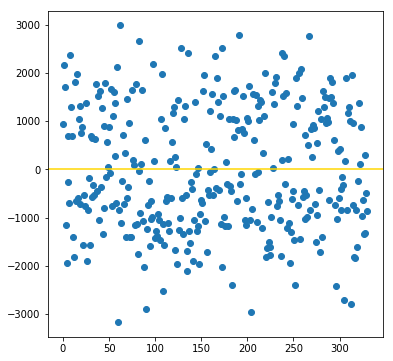

In [58]:
errors=Y_train-regression_b.predict(X_train_b)
vec = np.linspace(0, 330, num=331)
fig,ax=plt.subplots(1,1,figsize=(6,6))
plt.scatter(vec,errors)
plt.axhline(y=0,color='gold')


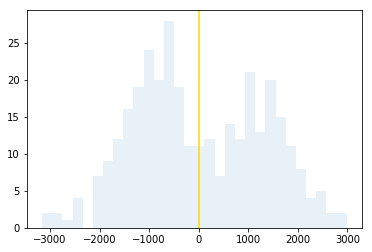

In [59]:
#The idea is to test wether the t-test is a valid estimation for
#checking the importance of each predictor
plt.hist(errors,alpha=0.1,bins=30,linewidth=1)
plt.axvline(x=0, color='gold', label='zero error')

## Part (c): Checking Collinearity

Does the data suffer from multi-collinearity? To answer this question, let us first analyze the correlation matrix for the data. Compute the (Pearson product-moment) correlation matrix for the predictor variables in the training set, and visualize the matrix using a heatmap. For categorical attributes, you should use each binary predictor resulting from one-hot encoding to compute their correlations.  Are there predictors that fall into natural groups based on the correlation values? 

*Hint:* You may use the `np.corrcoef` function to compute the correlation matrix for a data set (do not forget to transpose the data matrix). You may use `plt.pcolor` function to visualize the correlation matrix.

In [60]:
#devide to logical groups that migh be correlated

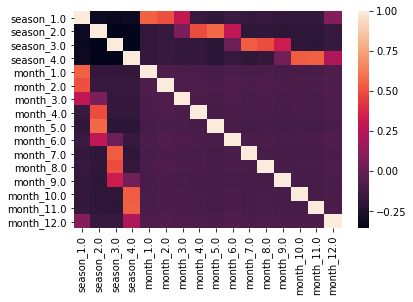

In [61]:
X_train_period=df_final[[ 'season_1.0','season_2.0', 'season_3.0', 'season_4.0',                                
                       'month_1.0','month_2.0', 'month_3.0', 'month_4.0', 'month_5.0', 'month_6.0', 'month_7.0',
                        'month_8.0', 'month_9.0', 'month_10.0', 'month_11.0', 'month_12.0',
                    #                 
                        ]].values                    




df_period=pd.DataFrame(X_train_period, columns=
                     [ 'season_1.0','season_2.0', 'season_3.0', 'season_4.0',                       
                      'month_1.0','month_2.0', 'month_3.0', 'month_4.0', 'month_5.0', 'month_6.0', 'month_7.0',
                    'month_8.0', 'month_9.0', 'month_10.0', 'month_11.0', 'month_12.0',
                   
                        ])
corr_period=df_period.corr()
sns.heatmap( corr_period         
           )

In [62]:
#according to this plot the seasons should be :1- winter, 2-spring, 3-summer, 4-fall

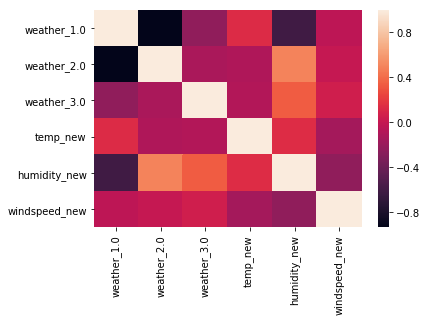

In [63]:
X_train_weather=df_final[[          
                       'weather_1.0', 'weather_2.0', 'weather_3.0',
                      'temp_new',
                   #   'atemp_new',
                     'humidity_new',
                      'windspeed_new',                        
                   
                        ]].values                
dfa_weather=pd.DataFrame(X_train_weather, columns=
                     [ 
                     'weather_1.0', 'weather_2.0', 'weather_3.0',
                     'temp_new',
                    # 'atemp_new',
                      'humidity_new',
                       'windspeed_new',                        
                        ])
corr_weather=dfa_weather.corr()
sns.heatmap( corr_weather 
           )

In [64]:
#the weather nums and the attributes are correlated

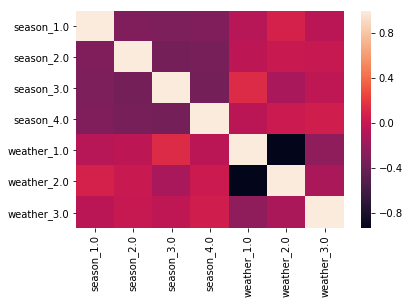

In [65]:
X_train_ws=df_final[[   'season_1.0','season_2.0', 'season_3.0', 'season_4.0',   
                            'weather_1.0', 'weather_2.0', 'weather_3.0'
                        ]].values                    

dfa_ws=pd.DataFrame(X_train_ws, columns=
                     ['season_1.0','season_2.0', 'season_3.0', 'season_4.0',  
                       'weather_1.0', 'weather_2.0', 'weather_3.0',
                        ])

corr_ws=dfa_ws.corr()
sns.heatmap( corr_ws
           )

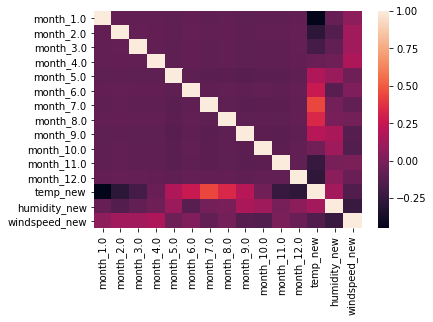

In [76]:
X_train_weather_1=df_final[[          
                  #  'weather_1.0', 'weather_2.0', 'weather_3.0',
                  # 'season_1.0','season_2.0', 'season_3.0', 'season_4.0', 
                   'month_1.0','month_2.0', 'month_3.0', 'month_4.0', 'month_5.0', 'month_6.0', 'month_7.0',
                   'month_8.0', 'month_9.0', 'month_10.0', 'month_11.0', 'month_12.0',
                    'temp_new',
                   #   'atemp_new',
                    'humidity_new',
                    'windspeed_new',                        
                   
                        ]].values                
dfa_weather_1=pd.DataFrame(X_train_weather_1, columns=
                     [ 
                  # 'weather_1.0', 'weather_2.0', 'weather_3.0',
                  #  'season_1.0','season_2.0', 'season_3.0', 'season_4.0', 
                 'month_1.0','month_2.0', 'month_3.0', 'month_4.0', 'month_5.0', 'month_6.0', 'month_7.0',
                   'month_8.0', 'month_9.0', 'month_10.0', 'month_11.0', 'month_12.0',   
                    'temp_new',
                    # 'atemp_new',
                    'humidity_new',
                    'windspeed_new',                        
                        ])
corr_weather_1=dfa_weather_1.corr()
sns.heatmap( corr_weather_1 
           )

In [67]:
#season and weather almost not correlated ????

In [885]:
#humidity correlated with weather
#atemp and temp are anti-correlated
#check what gives better prediction season or month ,they seem slightly correlated

your answers here

## Part (d): Subset Selection

Apply either one of the following subset selection methods discussed in class to choose a minimal subset of predictors that are related to the response variable:
- Step-wise forward selection
- Step-wise backward selection

We require you to implement both these methods *from scratch*. You may use the Bayesian Information Criterion (BIC) to choose the subset size in each method. Do these methods eliminate one or more of the redundant predictors (if any) identified in Part (c)? In each case, fit linear regression models using the identified subset of predictors to the training set. How do the test $R^2$ scores for the fitted models compare with the model fitted in Part (b) using all predictors?




In [ ]:
#Analysis by hand , what predictors give bareble R^2

In [2813]:
multi_regression_model_q = LinearRegression(fit_intercept=True)

cols_t = [
    'month_4.0', 'month_9.0', 'month_10.0', 'month_11.0',  'weather_3.0',  'temp_new',  'humidity_new',     'windspeed_new',
         ]
train_R_sq = []
test_R_sq = []
for i in range(1, len(cols_t)+1):
    predictors = cols_t[:i]
    X_train_u = df_final[predictors].values
    X_test = df_final[predictors].values
    
    multi_regression_model_q.fit(X_train_u, Y_train)
    
    train_R_sq.append(multi_regression_model_q.score(X_train_u, Y_train))
    



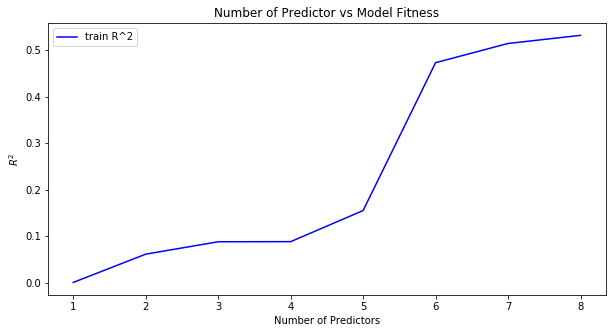

In [2814]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(range(1, len(cols_t)+1), train_R_sq, color='blue', label='train R^2')


ax.set_title('Number of Predictor vs Model Fitness')
ax.set_xlabel('Number of Predictors')
ax.set_ylabel('$R^2$')
ax.legend(loc='best')
#ax.set_ylim([0.5,0.57])
plt.show()


your answers here

In [ ]:
#the most important factors are temp and humidity and windspeed , the rest are less influencial
#When the months are one of:4,9,10,11
# When temp, humidity and windspeed allow- people are likely to rent a byckle

In [3028]:
multi_regression_model_val = LinearRegression(fit_intercept=True)
cols_v=col1  


In [ ]:
train_R_sq = []
test_R_sq = []
predictors = [cols_v[0] ]
for i in range(1, len(cols_v)):
    test_col=cols_v[i]
    predictors.append(test_col)
    l=len(predictors)
    X_train_u = df_final[predictors].values          
    result_val = sm.OLS( Y_train,X_train_u ).fit()
    for k in range(0,(result_val.pvalues.size)):

In [2843]:
#forwards selection
train_R_sq = []
test_R_sq = []
predictors = [cols_v[0] ]
for i in range(1, len(cols_v)):
         test_col=cols_v[i]          
         predictors.append(test_col)
         l=len(predictors)       
         X_train_u = df_final[predictors].values          
         result_val = sm.OLS( Y_train,X_train_u ).fit()
         for k in range(0,(result_val.pvalues.size)):
        # if result_val.pvalues[l-1] >0.05 :   
            if result_val.pvalues[k] >0.05 :
                #  predictors.remove(test_col)
                predictors = predictors[:k] + predictors[k+1 :]
                   
predictors

['season_2.0',
 'season_4.0',
 'month_9.0',
 'weather_1.0',
 'weather_2.0',
 'temp_new',
 'humidity_new',
 'windspeed_new',
 'Eins']

In [2846]:
X_train_h=df_final[ predictors ].values 
result_h = sm.OLS( Y_train,X_train_h ).fit()
result_h.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.539
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     46.98
Date:                Fri, 05 Jan 2018   Prob (F-statistic):           9.52e-50
Time:                        13:12:16   Log-Likelihood:                -2846.2
No. Observations:                 331   AIC:                             5710.
Df Residuals:                     322   BIC:                             5745.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           766.6744    183.164      4.186      0.000     406.325    1127.024
x2          1206.7023    188.240      6.410      0.000     836.366    1577.038
x3          1086.8620    259.952      4.181      0.000     575.444    1598.280
x4          1545.3947    512.562      3.015      0.003     537.001    2553.789
x5          1476.1639    462.869      3.189      0.002     565.534    2386.794
x6          1174.6564     82.680     14.207      0.000    1011.995    1337.318
x7          -504.4078    108.784     -4.637      0.000    -718.424    -290.392
x8          -249.8978     78.967     -3.165      0.002    -405.254     -94.542
const       2505.1067    483.900      5.177      0.000    1553.101    3457.112
==============================================================================
Omnibus:                       21.262   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                8.319
Skew:                           0.065   Prob(JB):                       0.0156
Kurtosis:                       2.234   Cond. No.                         14.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2741]:
#The list of imprortant predictors by t-test with forward selection model:
#['season_2.0', 'season_4.0', 'month_9.0', 'weather_1.0', 'weather_2.0', 'temp_new', 'humidity_new', 'windspeed_new',]


#BY me:  giver slghtly better R^2
#'month_4.0','month_9.0', 'month_10.0', 'month_11.0',  
#'temp_new',  'humidity_new',   'windspeed_new', 'weather_3.0', 

#the different parameter give slight imporvement by they are less unfluential
                       
#I tried to make more logical model based on predictors :  
#'season_1.0',    
#'temp_new',  'humidity_new',   'windspeed_new', 'weather_3.0', 
#the last allows more logical evaluation of predictors
# no meaningfull reason to include both season and month , since the somehow correlated
# thus , with small reduction of r^square we can include smaller number of predictors                   
                       
                           

## Part (e): Cross Validation

- Perform a 10-fold cross-validation procedure to select between the 3 competing models you have so far: the model with the best BIC from Step-wise forward selection, the model with the best BIC from Step-wise backward selection (if it is different), and the model with all possible predictors.  Report the average $R^2$ across all 10 validation sets for each model and compare the results.  Why do you think this is the case?
- Evaluate each of the 3 models on the provided left out test set by calculating $R^2$.  Do the results agree with the cross-validation?  Why or why not?

In [ ]:
# Since we don't have a large amount of data the cross validation procedure is necesary.
#The cross validation procedure is required in order to BOOST THE CONFIDENCE in the model selection

In [ ]:
#Also posible to perform croww validation on the predictor selecton by choosing the best R^2

In [2935]:
n_folds=10
kfold = KFold(n_folds)

train_errors = np.zeros((n_folds))
valid_errors = np.zeros((n_folds))
r_squared_all = np.zeros((n_folds))
r_squared_ch = np.zeros((n_folds))
#list(kfold.split(range(20)))

In [2956]:
#Average  R2R2  across all 10 validation sets for all predictors model
fold = 0

for train, valid in KFold(n_folds, shuffle=True).split(range(331)): # split data into train/test groups,10 times
    train_dict, valid_dict = X_train_a[train], X_train_a[valid]          
    est = LinearRegression(fit_intercept=True)
    est.fit(train_dict, Y_train[train]) # fit 
    r_squared_all[fold]= r2_score(Y_train[valid], est.predict(valid_dict))
  #  train_errors[fold] = mean_squared_error(Y_train[train], est.predict(train_dict)) # evaluate score function on held-out data
  #  valid_errors[fold] = mean_squared_error(Y_train[valid], est.predict(valid_dict)) # evaluate score function on held-out data
    fold += 1 
print(r_squared_all)     
print ('Average R^2 for all predictors:',np.mean( r_squared_all))

[ 0.39965126  0.62065746  0.64041639  0.37225988  0.44429722  0.0533751
  0.40699522  0.35942827  0.24704904  0.6296303 ]
Average R^2 for all predictors: 0.41737601511


In [2961]:
#Average  R2  across all 10 validation sets for forward selected predictors model
X_train_ch=df_final[ predictors[:8] ].values

fold = 0

for train, valid in KFold(n_folds, shuffle=True).split(range(331)): # split data into train/test groups,10 times
    train_dict, valid_dict = X_train_ch[train], X_train_ch[valid]          
    est_1 = LinearRegression(fit_intercept=True)
    est_1.fit(train_dict, Y_train[train]) # fit 
    r_squared_ch[fold]= r2_score(Y_train[valid], est_1.predict(valid_dict))
  #  train_errors[fold] = mean_squared_error(Y_train[train], est.predict(train_dict)) # evaluate score function on held-out data
  #  valid_errors[fold] = mean_squared_error(Y_train[valid], est.predict(valid_dict)) # evaluate score function on held-out data
    fold += 1   
print(r_squared_ch)   
print ('Average R^2 for chosen predictors:',np.mean( r_squared_ch))

[ 0.52048657  0.58189447  0.44266977  0.24529404  0.62220925  0.55446294
  0.66012572  0.45002603  0.4253051   0.50745537]
Average R^2 for chosen predictors: 0.500992927085


In [2951]:
#The model with th echosen predictors gives better R^2:
# by ommiting several predictors that gave only insignificant dependence on them,
# we allowed the model to find aa better fitting ceficients based on the significant predictors.